Изработил: Ангела Андоновски 93/2019

# <center>Проектна задача по Машинско учење</center>
## <center>Предикција на сентименталноста изразена во твитовите</center>

Целта на проектната задача е да се развие алгоритам базиран на машинско учење со кој автоматски се анализира и класифицира сентименталноста изразена во твитовите. Со користење на рекурентнa невронскa мрежa (LSTM) и Support Vector Machines (SVM) се овозможува утврдување дали твитовите пренесуваат позитивни, негативни или неутрални чувства.

## Содржина

0. [Вчитување на потребни библиотеки](#bib)
1. [Опис на проблемот кој се решава](#opis)
    - [Податочно множество](#pod)
    - [Визуелизација на податоците](#viz)
    - [Опис на користените метрики](#met)
2. [Користени пристапи од машинско учење за решавање на проблемот](#pristapi)
    - [Опис на алгоритам 1](#prist1)
    - [Опис на алгоритам 2](#prist2)
  
3. [Решавање на проблемот](#res)
    - [Решавање со алгоритам 1](#res1)
    - [Решавање со алгоритам 2](#res2)
  
4. [Споредба на резултатите](#spor)
5. [Пост-оптимизирачка анализа](#postop)
6. [Заклучок](#zakl)
7. [Користена литература и ресурси](#resources)

## 0. Вчитување на потребни библиотеки <a id='bib'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score, KFold
import re
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier


## 1. Опис на проблемот кој се решава <a id='opis'></a>

Проблемот вклучува препознавање и категоризирање на чувствата изразени во твитовите постирани на Твитер. Станува збор за големо текстуално податочно множество и поради тоа мануелното утврдување дали твитот носи позитивно, негативно или неутрално чувство е непрактично и одзема многу време. Овој проект се обидува да одговори на овој предизвик преку развивање на автоматизирано решение - алгоритам што може да го анализира јазикот што се користи во твитовите и прецизно да ги класифицира во категории на чувства. Ова ќе овозможи ефикасна анализа на чувствата, помагајќи им на бизнисите, истражувачите и аналитичарите на социјалните медиуми да добијат значајни увиди од множеството податоци споделени на Твитер.

### 1.1. Податочно множество <a id='pod'></a>

Вчитување на податочното множество и негово процесирање.

In [2]:
dataset=pd.read_csv('Tweets.csv')
dataset=dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,568109390026448896,negative,1.0000,Customer Service Issue,1.0,Delta,NaN,j_beatz247,NaN,0,@JetBlue you respond to my friend @LisaPal but...,NaN,2015-02-18 10:06:48 -0800,new orleans,NaN
1,568064842466250752,negative,1.0000,Lost Luggage,1.0,United,NaN,dexhandle,NaN,0,@united Filled out at the airport as part of a...,NaN,2015-02-18 07:09:47 -0800,DC,Eastern Time (US & Canada)
2,569184255399620608,neutral,0.6842,NaN,NaN,Delta,NaN,kbosspotter,NaN,0,@JetBlue the you above all commercials? Like t...,NaN,2015-02-21 09:17:56 -0800,Logan International Airport,Atlantic Time (Canada)
3,568912730742255616,negative,1.0000,Customer Service Issue,1.0,US Airways,NaN,drKCfoot,NaN,0,@USAirways technical issues = inefficient comp...,NaN,2015-02-20 15:18:59 -0800,Philly,Eastern Time (US & Canada)
4,568965309505380352,negative,1.0000,Cancelled Flight,1.0,Southwest,NaN,PamR413,NaN,0,@SouthwestAir Loved one's flight ATL to IND Ca...,NaN,2015-02-20 18:47:55 -0800,NaN,Eastern Time (US & Canada)


### 1.2. Визуелизација на податоците <a id='viz'></a>

Податоците ги визуелизираме од различни аспекти за да доловиме некои зависности и одлики на нивните карактеристики, и да ја анализираме нивната природа и структура.


In [3]:
dataset.shape #димензија на податоците,дводимензионален dataset т.е матрица со 14640 редови и 15 колони

(14640, 15)

Од даденото податочно множество кое има 15 колони и 14640 редови, за понатамошната анализа ни се потребни само две колони: 'airline_sentiment'(output колона) и 'text'(input колона). Oстанатите колони не носат релевантна информација за проблемот кој треба да се реши.

In [4]:
dataset = dataset[['airline_sentiment','text']]
dataset.head()

,airline_sentiment,text
0,negative,@JetBlue you respond to my friend @LisaPal but...
1,negative,@united Filled out at the airport as part of a...
2,neutral,@JetBlue the you above all commercials? Like t...
3,negative,@USAirways technical issues = inefficient comp...
4,negative,@SouthwestAir Loved one's flight ATL to IND Ca...


<Axes: ylabel='Frequency'>

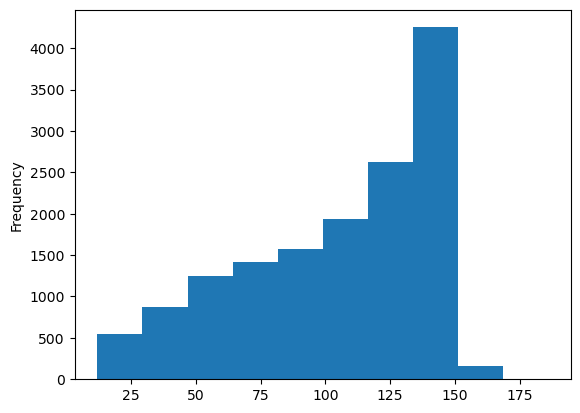

In [5]:
%matplotlib inline 
dataset['text'].str.len().plot.hist()

In [6]:
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<Axes: >

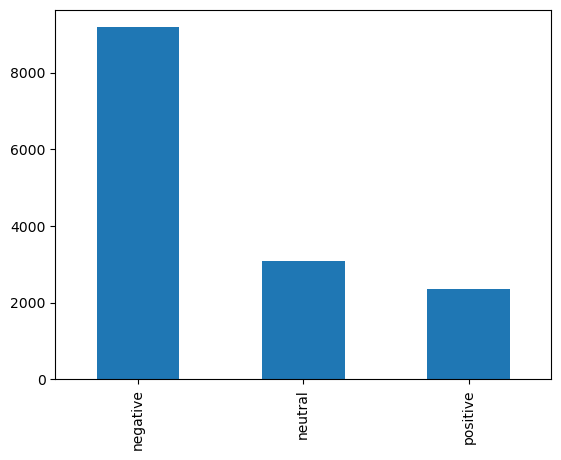

In [7]:
dataset['airline_sentiment'].value_counts().plot.bar()

In [8]:
dataset['text'].apply(lambda x: x.lower())
dataset['text']= dataset['text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]',"",x))
dataset['text'].head()

0    JetBlue you respond to my friend LisaPal but y...
1    united Filled out at the airport as part of a ...
2    JetBlue the you above all commercials Like the...
3    USAirways technical issues  inefficient comput...
4    SouthwestAir Loved ones flight ATL to IND Canc...
Name: text, dtype: object

In [9]:
tokenizer = Tokenizer(num_words = 5000, split=" ") # се оставаат најфреквентните 5000 зборови
tokenizer.fit_on_texts(dataset['text'].values) # на податоците се поставува tokenizer и се конвертираат во numpy array

X=tokenizer.texts_to_sequences(dataset['text'].values) #конверзија на зборовите во броеви
X=pad_sequences(X) #сите твитови да имаат иста должина
X[:7]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   17,    6,
         691,    1,   11,  553,   31,    6,   70,  691, 1508,    1,   19],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    5, 1204,   52,
          27,    2,  110,   86,  775,   18,    4,  214,  119,  184,  520],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   17,    2,    6, 1205,   67, 2455,   95,    2, 1427,   74],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   12, 2054,  294, 3092,
         645,  260, 1784,   18, 3093,   24,  729, 1311,   18,  729,  412],
       [   0,    0,    0,    0,    0,    0,    0,    0,   16, 1161, 1162,
           8,  743,    1, 1914,   

In [10]:
X.shape

(14640, 33)

## 1.3. Опис на користените метрики <a id='met'></a>

Токенизацијата вклучува сегментирање на континуирана низа од текст во дискретни единици кои се наречени токени. Овие токени може да бидат зборови, подзборови , или дури и знаци, во зависност од избраната стратегија за токенизација.
Токенизаторите користат разграничувачи или сепаратори за да одредат каде завршува еден токен, а каде започнува друг. Вообичаените сепаратори на англискиот јазик вклучуваат празни места и интерпункциски знаци (на пр.запирки, точки). 
Токенизацијата мора да се справи со посебни случаи, како што се контракции (на пр. "can't"  треба да се токенизира во  "can" и "n't" и зборови со цртичка (на пр. "mother-in-law"  треба да биде единствен токен).
Математички, токенизацијата ги дефинира почетните и крајните граници на секој токен во низа од знаци. Овие граници се клучни за прецизно разделување на текстот. Токенизацијата може да вклучи и математичка нормализација, како што е конвертирање на целиот текст во мали букви за да се обезбеди конзистентност во претставувањето на токените.

## 2. Користени пристапи од машинско учење за решавање на проблемот <a id='pristapi'></a>

Користени се два различни алгоритми за решавање на проблемот.

### 2.1. Опис на алгоритам 1 <a id='prist1'></a>
Long Short-term Memory(LSTM) е тип na рекурентна невронска мрежа (RNN) што се користи во длабоко учење и обработка на природен јазик(natural language processing). LSTM мрежите се дизајнирани за ефективно запишување и запомнување на long-range зависностите во секвенцијалните податоци. Тие го постигнуваат ова со инкорпорирање на специјализирани мемориски ќелии кои можат да складираат и ажурираат информации преку продолжени секвенци, што ги прави добро прилагодени за задачи како што се препознавање говор, моделирање јазик и анализа на time series. Способноста на LSTM да се справува со long-term и short-term примероци во податоците го прави моќна алатка во различни апликации за машинско учење, овозможувајќи попрецизни предвидувања и подобрено разбирање на секвенцијалните информации.

Структурата на LSTM се состои од 3 главни компоненти:
* **Cell state:** се однесува како мемориска единица, складирајќи информации со текот на времето. Може да се ажурира, чита и запишува со користење на различни порти, кои го контролираат протокот на информации во и надвор од ќелијата.
* **Hidden state:** носи информации за излезот на тековниот временски чекор(time step) и е под влијание на состојбата на ќелијата и влезот во тој временски чекор(time step).
* **Gates:** Forget Gate:одредува кои информации од претходната cell state треба да се отфрлат и кои нови информации треба да се складираат. Input Gate: модулира колку нови информации треба да се вградат во cell state. Output Gate:контролира кои информации од cell state треба да се користат за пресметување на излезот во тековниот временски чекор.

Параметри на LSTM se:
* **Weighted matrices** (W_i, W_f, W_c, W_o): oвие матрици ја контролираат трансформацијата на влезните податоци и скриените состојби за input gate, forget gate, ажурирањето на cell state и излезот.
* **Bias Matrices** (b_i, b_f, b_c, b_o): се додаваат на тежинскиот влез(weighted input) и помагаат во процесот на трансформирање на секоја од портите(gates).
  
Хиперпараметри на LSTM се:
    Број на LSTM cells(units), број на слоеви на невронската мрежа, Dropout: техника за регуларизација која по случаен избор поставува дел од активирањата на LSTM невроните на нула за време на тренингот за да се спречи overfitting, Еpochs: претставува колку пати моделот гледа и учи од целата база на податоци, Batch size: се однесува на бројот на примероци за тренирање или точки на податоци што се користат во еден напред и назад премин низ невронската мрежа за време на секое повторување на тренирањето.

### 2.2. Опис на алгоритам 2 <a id='prist2'></a>
Support Vector Machines(SVM) е моќен алгоритам за машинско учење што се користи за задачи за класификација и регресија. Работи со наоѓање на оптимална хиперрамнина која најдобро ги одвојува податочните точки кои припаѓаат на различни класи во простор со високи димензии. SVM има за цел да ја максимизира маргината помеѓу овие класи, правејќи го робустен за overfitting и високо ефективен во сценарија со сложени граници на одлуки. Овој алгоритам е широко применет во полиња како класификација на слики, категоризација на текст и биоинформатика поради неговата разновидност и способност да се справи со линеарни и нелинеарни врски во податоците.
Во случаите каде што податоците не се совршено раздвојливи со хиперрамнина, SVM воведува soft margin, контролирана од хиперпараметарот C. Помала C вредност овозможува поширока маргина, но може да толерира некои погрешни класификации, додека поголема вредност C создава потесна маргина, но спроведува построга класификација.SVM може да  ракува со нелинеарни податоци со тоа што ги мапира во простор со поголема димензија користејќи kernel function(на пр., полиномни или радијални функциски кернели). Во овој трансформиран простор, хиперрамнината често може линеарно да ги одвои податоците, правејќи го SVM способен да решава нелинеарни проблеми со класификација.

Еден од клучните аспекти при тренирање на еден SVM модел е нагодување на неговите параметри за тренирање. Еден од највлијателните параметри се:

* **C:** Параметар на регуларизација. Јачината на регуларизација е инверзно пропорционална на C. За регуларизација се користи l2 норма. Множество на вредности: **[0, inf]**
* **gamma**: Коефициент на јадрото(kernel). Во случајот на гаусово јадро, овој параметер ја одредува стрмноста на функцијата. Множество на вредности: **[0, inf]**
* **kernel**: Тип на јадро кое ќе го користи алгоритмот. Јадрото се применува со цел да се овозможи линеарна раздвојливост на податочното множество. Целта е да се преслика секоја од точка од податочното множество во повеќе димензионален простор каде што ќе се овозможи линеарна раздвојливост на множеството. Множество на вредности: **[‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’]**
* **degree**: Се одредува степенот на полиномот во случаи кога се користи полиномно јадро.

## 3. Решавање на проблемот <a id='res'></a>

### 3.1. Решавање со алгоритам 1 <a id='res1'></a>

In [11]:
model = Sequential()

model.add(Embedding(5000,256,input_length=X.shape[1])) #for each of those 5000 different words we want to crate a new vector which is currently 256 long
model.add(Dropout(0.3))
model.add(LSTM(256,return_sequences=True, dropout=0.3, recurrent_dropout=0.2))

model.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(LSTM(256,dropout = 0.3, recurrent_dropout=0.2))

model.add(Dense(3,activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 256)           1280000   
                                                                 
 dropout (Dropout)           (None, 33, 256)           0         
                                                                 
 lstm (LSTM)                 (None, 33, 256)           525312    
                                                                 
 lstm_1 (LSTM)               (None, 33, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 33, 128)           0         
                                                                 
 dense (Dense)               (None, 33, 64)            8256      
                                                                 
 dropout_2 (Dropout)         (None, 33, 64)            0

In [13]:
y= pd.get_dummies(dataset['airline_sentiment']).values
[print(dataset['airline_sentiment'][i], y[i] )for i in range(0,7)]

negative [1 0 0]
negative [1 0 0]
neutral [0 1 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]


[None, None, None, None, None, None, None]

In [14]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2,random_state=0)

In [15]:
batch_size=32
epochs=10
model.fit(X_train, y_train, epochs=epochs,batch_size=batch_size,verbose=2)

Epoch 1/10


2023-09-19 00:22:53.739761: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


366/366 - 85s - loss: 0.7074 - accuracy: 0.6989 - 85s/epoch - 232ms/step
Epoch 2/10
366/366 - 90s - loss: 0.4877 - accuracy: 0.8166 - 90s/epoch - 247ms/step
Epoch 3/10
366/366 - 90s - loss: 0.3878 - accuracy: 0.8566 - 90s/epoch - 245ms/step
Epoch 4/10
366/366 - 91s - loss: 0.3192 - accuracy: 0.8855 - 91s/epoch - 248ms/step
Epoch 5/10
366/366 - 91s - loss: 0.2734 - accuracy: 0.9045 - 91s/epoch - 248ms/step
Epoch 6/10
366/366 - 92s - loss: 0.2250 - accuracy: 0.9204 - 92s/epoch - 250ms/step
Epoch 7/10
366/366 - 90s - loss: 0.1977 - accuracy: 0.9300 - 90s/epoch - 246ms/step
Epoch 8/10
366/366 - 90s - loss: 0.1688 - accuracy: 0.9405 - 90s/epoch - 245ms/step
Epoch 9/10
366/366 - 89s - loss: 0.1474 - accuracy: 0.9486 - 89s/epoch - 244ms/step
Epoch 10/10
366/366 - 90s - loss: 0.1301 - accuracy: 0.9541 - 90s/epoch - 246ms/step


In [16]:
prediction= model.predict(X_test)
[print(dataset['text'][i],y_test[i], prediction[i]) for i in range(0,12)]

92/92 [==============================] - 4s 44ms/step
JetBlue you respond to my friend LisaPal but you cant respond directly to me [1 0 0] [0.9009423  0.0845656  0.01449211]
united Filled out at the airport as part of a long day made longer [1 0 0] [0.9902632  0.00864202 0.00109482]
JetBlue the you above all commercials Like the legroom one [1 0 0] [0.98273164 0.01437774 0.00289055]
USAirways technical issues  inefficient computer triage system Personality compassion of operators  not Sad example of sad company [1 0 0] [0.96029794 0.03689336 0.00280863]
SouthwestAir Loved ones flight ATL to IND Cancelled Flightled due to ice in Indy Sitting here in Indy it is bone dry Tomorrow 46 of snow [0 0 1] [4.1967435e-04 1.8516129e-02 9.8106420e-01]
AmericanAir because of you I am doing the one thing I tried to avoid Thank you for sending me to baggage claim [1 0 0] [9.9884331e-01 1.0871353e-03 6.9590184e-05]
SouthwestAir thanks More concerned about the conflicting texts I was receiving my about 

[None, None, None, None, None, None, None, None, None, None, None, None]

In [17]:
#Конверзија на рredictions (continuous value) во Multi-Label Indicator Format
continuous_multioutput_values = prediction
threshold = 0.5
multi_label_indicators = (continuous_multioutput_values >= threshold).astype(int)
print("Multi-Label Indicator Format:")
print(multi_label_indicators)


Multi-Label Indicator Format:
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [19]:
f1 = f1_score(y_test,multi_label_indicators,average='weighted') 
print("F1-Score:", f1)

F1-Score: 0.76628438760469


In [20]:
accuracy = accuracy_score(y_test,multi_label_indicators)
print("Accuracy:", accuracy)

report = classification_report(y_test,multi_label_indicators)
print("Classification Report:\n", report)

Accuracy: 0.7681010928961749
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1838
           1       0.60      0.50      0.54       622
           2       0.71      0.68      0.70       468

   micro avg       0.78      0.77      0.77      2928
   macro avg       0.72      0.69      0.70      2928
weighted avg       0.77      0.77      0.77      2928
 samples avg       0.77      0.77      0.77      2928



/Users/angelaandonovski/miniconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.1.1 Примена на k-fold cross validation со алгоритам 1 <a id='res1'></a>

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Се осигуруваме дека target labels се нумерички енкодирани 
label_encoder = LabelEncoder()
y_indices = np.argmax(y, axis=1)
y_encoded = label_encoder.fit_transform(y_indices)  

# Конверзија во one-hot format 
y_onehot = to_categorical(y_encoded)


k = 3
accuracy_scores = []
f1_scores = []

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)


for train_index, test_index in skf.split(X, y_encoded):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_onehot[train_index], y_onehot[test_index]
    
    # Дефинирање и тренирање на LSTM моделот
    model = Sequential()

    model.add(Embedding(5000,256,input_length=X.shape[1])) 
    #model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(LSTM(256,return_sequences=True, dropout=0.3, recurrent_dropout=0.2))

    model.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(LSTM(256,dropout = 0.3, recurrent_dropout=0.2))

    model.add(Dense(3,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    model.fit(X_train, y_train, epochs=10,batch_size=32,verbose=2)
    
    
    # Евалуација на моделот и калкулација на метриките
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_test_class = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_class, y_pred_class)
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')  

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)



mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean Accuracy: {mean_accuracy:.2f} (±{std_accuracy:.2f})")
print(f"Mean F1 Score: {mean_f1:.2f} (±{std_f1:.2f})")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 256)           1280000   
                                                                 
 dropout_3 (Dropout)         (None, 33, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 33, 256)           525312    
                                                                 
 lstm_4 (LSTM)               (None, 33, 128)           197120    
                                                                 
 dropout_4 (Dropout)         (None, 33, 128)           0         
                                                                 
 dense_2 (Dense)             (None, 33, 64)            8256      
                                                                 
 dropout_5 (Dropout)         (None, 33, 64)           

### 3.2. Решавање со алгоритам 2 <a id='res2'></a>

In [22]:
X=dataset['text']

In [23]:
y= pd.get_dummies(dataset['airline_sentiment']).values
[print(dataset['airline_sentiment'][i], y[i] )for i in range(0,7)]

negative [1 0 0]
negative [1 0 0]
neutral [0 1 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]


[None, None, None, None, None, None, None]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Градење на SVM модел
svm_classifier = SVC(kernel='linear')

multioutput_classifier = MultiOutputClassifier(svm_classifier)
# Конверзија на 1D text data(input data) во нумерички карактеристики
tfidf_vectorizer = TfidfVectorizer()
X_train_features = tfidf_vectorizer.fit_transform(X_train)
X_test_features = tfidf_vectorizer.transform(X_test)

multioutput_classifier.fit(X_train_features, y_train)

y_pred = multioutput_classifier.predict(X_test_features)

In [25]:
# Eвалуација на перформансoт на моделот 
accuracy_SVM = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1_SVM = f1_score(y_test, y_pred, average='weighted')
print("F1 score: ", f1)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.7581967213114754
F1 score:  0.7615391149277204
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      1825
           1       0.75      0.49      0.59       618
           2       0.85      0.62      0.71       485

   micro avg       0.84      0.78      0.81      2928
   macro avg       0.82      0.67      0.73      2928
weighted avg       0.83      0.78      0.80      2928
 samples avg       0.77      0.78      0.77      2928



/Users/angelaandonovski/miniconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.2.1 Примена на k-fold cross validation со алгоритам 2 <a id='res1'></a>

In [29]:
# Креирање на SVM класификатор со linear kernel 
svm_classifier = SVC(kernel='linear')

# Креирање на MultiOutputClassifier што поддржува multi-label класификација
multioutput_classifier = MultiOutputClassifier(svm_classifier)


tfidf_vectorizer = TfidfVectorizer()
X_train_features = tfidf_vectorizer.fit_transform(X_train)
X_test_features = tfidf_vectorizer.transform(X_test)


# k-fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(multioutput_classifier, X_train_features, y_train, cv=kf, scoring='accuracy')

# cross-validation scores
for fold_num, accuracy in enumerate(cross_val_scores, start=1):
    print(f"Fold {fold_num} Accuracy: {accuracy}")

# Kaлкулација на средната вредност на cross-validation accuracy
average_accuracy = np.mean(cross_val_scores)
print(f"Average Cross-Validation Accuracy: {average_accuracy}")

Fold 1 Accuracy: 0.7542662116040956
Fold 2 Accuracy: 0.7192832764505119
Fold 3 Accuracy: 0.7361229718189581
Fold 4 Accuracy: 0.7275832621690862
Fold 5 Accuracy: 0.740392826643894
Fold 6 Accuracy: 0.713065755764304
Fold 7 Accuracy: 0.7258753202391118
Fold 8 Accuracy: 0.7190435525192144
Fold 9 Accuracy: 0.7600341588385995
Fold 10 Accuracy: 0.726729291204099
Average Cross-Validation Accuracy: 0.7322396627251874


## 4. Споредба на резултатите <a id='spor'></a>

Text(0.5, 1.0, 'Споредба на алгоритмите според средната вредност на accuracy (k-fold cv)')

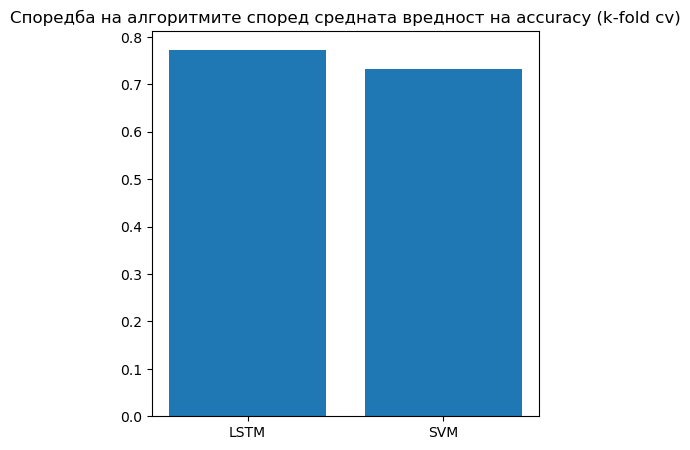

In [66]:
plt.figure(figsize=(5, 5))
models = ['LSTM', 'SVМ']
accuracies = (mean_accuracy,average_accuracy)
plt.bar(models, accuracies)
plt.title("Споредба на алгоритмите според средната вредност на accuracy (k-fold cv)")

Text(0.5, 1.0, 'Споредба на алгоритмите според f1 score')

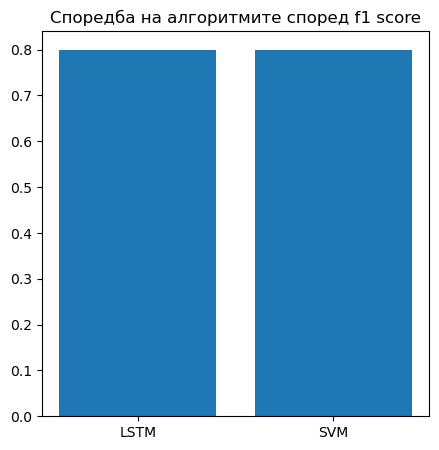

In [65]:
plt.figure(figsize=(5, 5))
models = ['LSTM', 'SVМ']
accuracies = (f1,f1_SVM)
plt.bar(models, accuracies)
plt.title("Споредба на алгоритмите според f1 score")

Text(0.5, 1.0, 'Споредба на алгоритмите според accuracy')

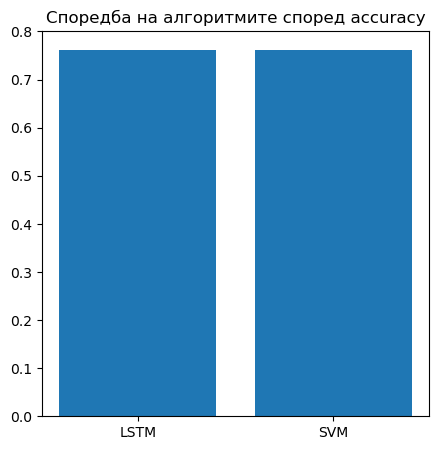

In [68]:
plt.figure(figsize=(5, 5))
models = ['LSTM', 'SVМ']
accuracies = (accuracy,accuracy_SVM)
plt.bar(models, accuracies)
plt.title("Споредба на алгоритмите според accuracy")

## 5. Пост-оптимизирачка анализа <a id='postop'></a>

Примарните метрики користени за евалуација на моделите се F1 score, кој го мери балансот меѓу precision и recall, и accuracy, која ја мери целокупната точност на предвидувањата. Вредноста на F1 score за двата модели e приближно 0.8, додека точноста(accuracy) e со вредност 0.74.

F1 score е важна метрика за анализа на сентименталноста бидејќи прави баланс меѓу precision( пропорцијата на true positives наспроти сите predicted positives) и recall (пропорцијата на true positives наспроти сите actual positives). Вредноста на F1 score од 0.8 се смета за добар резултат, индицирајќи дека и двата модели имаат прифатливо добар перформанс во однос на правилното класифицирање на чувства.

F1 score од 80% сугерира дека моделите можат ефективно да ги класифицираат и позитивните,негативните и неутралните чувства во твитовите.
Балансираниот F1 score  покажува дека моделите одржуваат добар trade-off помеѓу минимизирање на лажни позитиви(false positives) и лажни негативни(false negatives).

Точноста(аccuracy) ја мери целокупната исправност на предвидувањата, земајќи ги предвид и true positives и true negative. Точноста од 74% имплицира дека значителен дел од твитовите биле правилно класифицирани од двата модели односно дека моделите имаат разумно добри резултати во класифицирањето на твитовите во нивните соодветни категории. Важно е да се забележи дека на точноста може да влијание нерамнотежата на класите во базата на податоци.

Кога треба да избереме еден од алгоритмите, LSTM или SVM, за предвидување на сентименталноста, важно е да се разгледаат неколку фактори.
* **LSTM:** Предности на овој модел се тоа што e добро прилагоден за секвенцијални податоци како текст, може да фати сложени зависности во податоците, има потенцијал за понатамошно подобрување со подесување на хиперпараметри. Недостатоци се тоа што има потреба од поголема компјутациона моќ, побарува поголемo количество на податоци за тренирање за да генерализира ефективно.
   
* **SVM**: Силни страни на овој модел е тоа што е ефективен за high-dimensional feature spaces, ефикасни се за пресметка, едноставност и интерпретабилност. Негативнa странa на овој модел е тоа што не толку ефикасно ги oпишува секвенцијални зависности во податоците.


Следни чекори кои можат да се преземат за да се подобри перформансот на моделите се:

Да се истражи распределбата на класите во базата на податоци и да се истражат техниките како што се oversampling, undersampling или користење на различни метрики за оценување за да се решат потенцијалните проблеми со нерамнотежа на класите.

Евалуација на ефективноста на техниките за обработка на текст, како што се stemming, stop-word removal и ракување со специјални знаци или emojis.

Да се истражи можноста за комбинирање на предвидувањата од двата модели користејќи техники на ансамбл, како што се stacking или voting, за потенцијално подобрување на севкупните перформанси.



## 6. Заклучок <a id='zakl'></a>

Конечните резултати од овој проект за предвидување на чувствата, со користење на моделите Long Short-Term Memory(LSTM) и Support Vector Machines(SVM) индицираат значителен напредок во разбирањето и класифицирањето на чувствата во твитовите.

Финалните резултати, карактеризирани со 80% F1 score и 74% точност (accuracy) укажуваат дека постои ефикасна класификација на сентименталноста т.е. дека моделите се вешти во препознавање и доловување на емоционална содржина вградена во текстот, дури и во концизен и неформален контекст како твитовите. Балансираниот F1 score сугерира дека моделите постигнуваат баланс помеѓу precision и recall, ублажувајќи ги последиците од лажни позитиви и лажни негативни. Ова е клучно за апликации каде што погрешната класификација има различни нивоа на влијание. Точноста, иако не е исклучително висока, сепак означува дека значителен дел од твитовите се правилно класифицирани.

Значењето на проблемот лежи во неговиот потенцијал да поттикне подобро разбирање, ангажман на корисниците и одговорно управување со содржината во областа на социјалните медиуми.

## 7. Користена литература и ресурси <a class="anchor" id="resources"></a>


1. https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/
2. https://www.imperva.com/learn/data-security/tokenization/#:~:text=EssentialsRegulation%20%26%20Compliance-,What%20is%20Tokenization,or%20exploitable%20value%20or%20meaning.
3. https://www.kaggle.com/code/satishgunjal/tokenization-in-nlp
4. https://www.javatpoint.com/machine-learning-support-vector-machine-algorithm
